# Demonstration of delayed choice tasks

In [1]:
# Point Python to the path where we have installed the bad and darc packages
import sys
sys.path.insert(0, '/Users/btvincent/git-local/darc-experiments-python')

In [2]:
import pandas as pd
import numpy as np

import darc
from darc.delayed import models
from darc.designs import DARCDesign
from darc.delayed.designs import Kirby2009, Frye, Griskevicius2011, Koffarnus_Bickel
from dev.darc_parameter_recovery import parameter_recovery_sweep, simulated_experiment_trial_loop
from darc.data_plotting import plot_delay_without_front_end_delays

In [3]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Code for visualising the various design approaches
This will fill in columns 0-2 with data + posterior predictive discount functions. The point is to give insight into the placement of the designs and how that affects the esimates over $\log(k)$ and thus the posterior predictive visualisation of discount functions.

In [4]:
def hyperbolic_discount_func(delay, logk):
    k = np.exp(logk)
    return np.divide(1, (1 + k * delay))

def hyperbolic_posterior_predictive(ax, fitted_model):
    logk = fitted_model.θ['logk'].values  # get posterior samples
    delays = np.linspace(0, 365, 500)
    logk_percentiles = np.percentile(logk,[2.5, 50, 100-2.5])    
    
    y_upper = hyperbolic_discount_func(delays, logk_percentiles[2])
    y_median = hyperbolic_discount_func(delays, logk_percentiles[1])
    y_lower = hyperbolic_discount_func(delays, logk_percentiles[0])

    ax.fill_between(delays, y_lower, y_upper, alpha=0.3, label='95% CI')
    ax.plot(delays, y_median, label='posterior median')
    ax.legend()

Run simulated experiments

In [5]:
true_params = [pd.DataFrame.from_dict({'logk': [np.log(0.04)], 'α': [2]}),
               pd.DataFrame.from_dict({'logk': [np.log(0.01)], 'α': [2]}),
               pd.DataFrame.from_dict({'logk': [np.log(0.0028)], 'α': [2]})]

col_titles = ['major depressive disorder', 'upper income adult', 'anorexia nervosa']

BAD = lambda: DARCDesign(max_trials=20, 
                         RA=list(np.arange(5, 99+1, 1)), 
                         DB=list(np.arange(1, 365, 7)))

design_types = [Kirby2009, 
                Griskevicius2011, 
                Koffarnus_Bickel, 
                Frye,
                BAD]

row_headings = ['Kirby (2009)',
                'Griskevicius\n et al (2011)',
                'Koffarnus & Bickel\n (2014)',
                'Frye et al (2016)',
                'our approach']

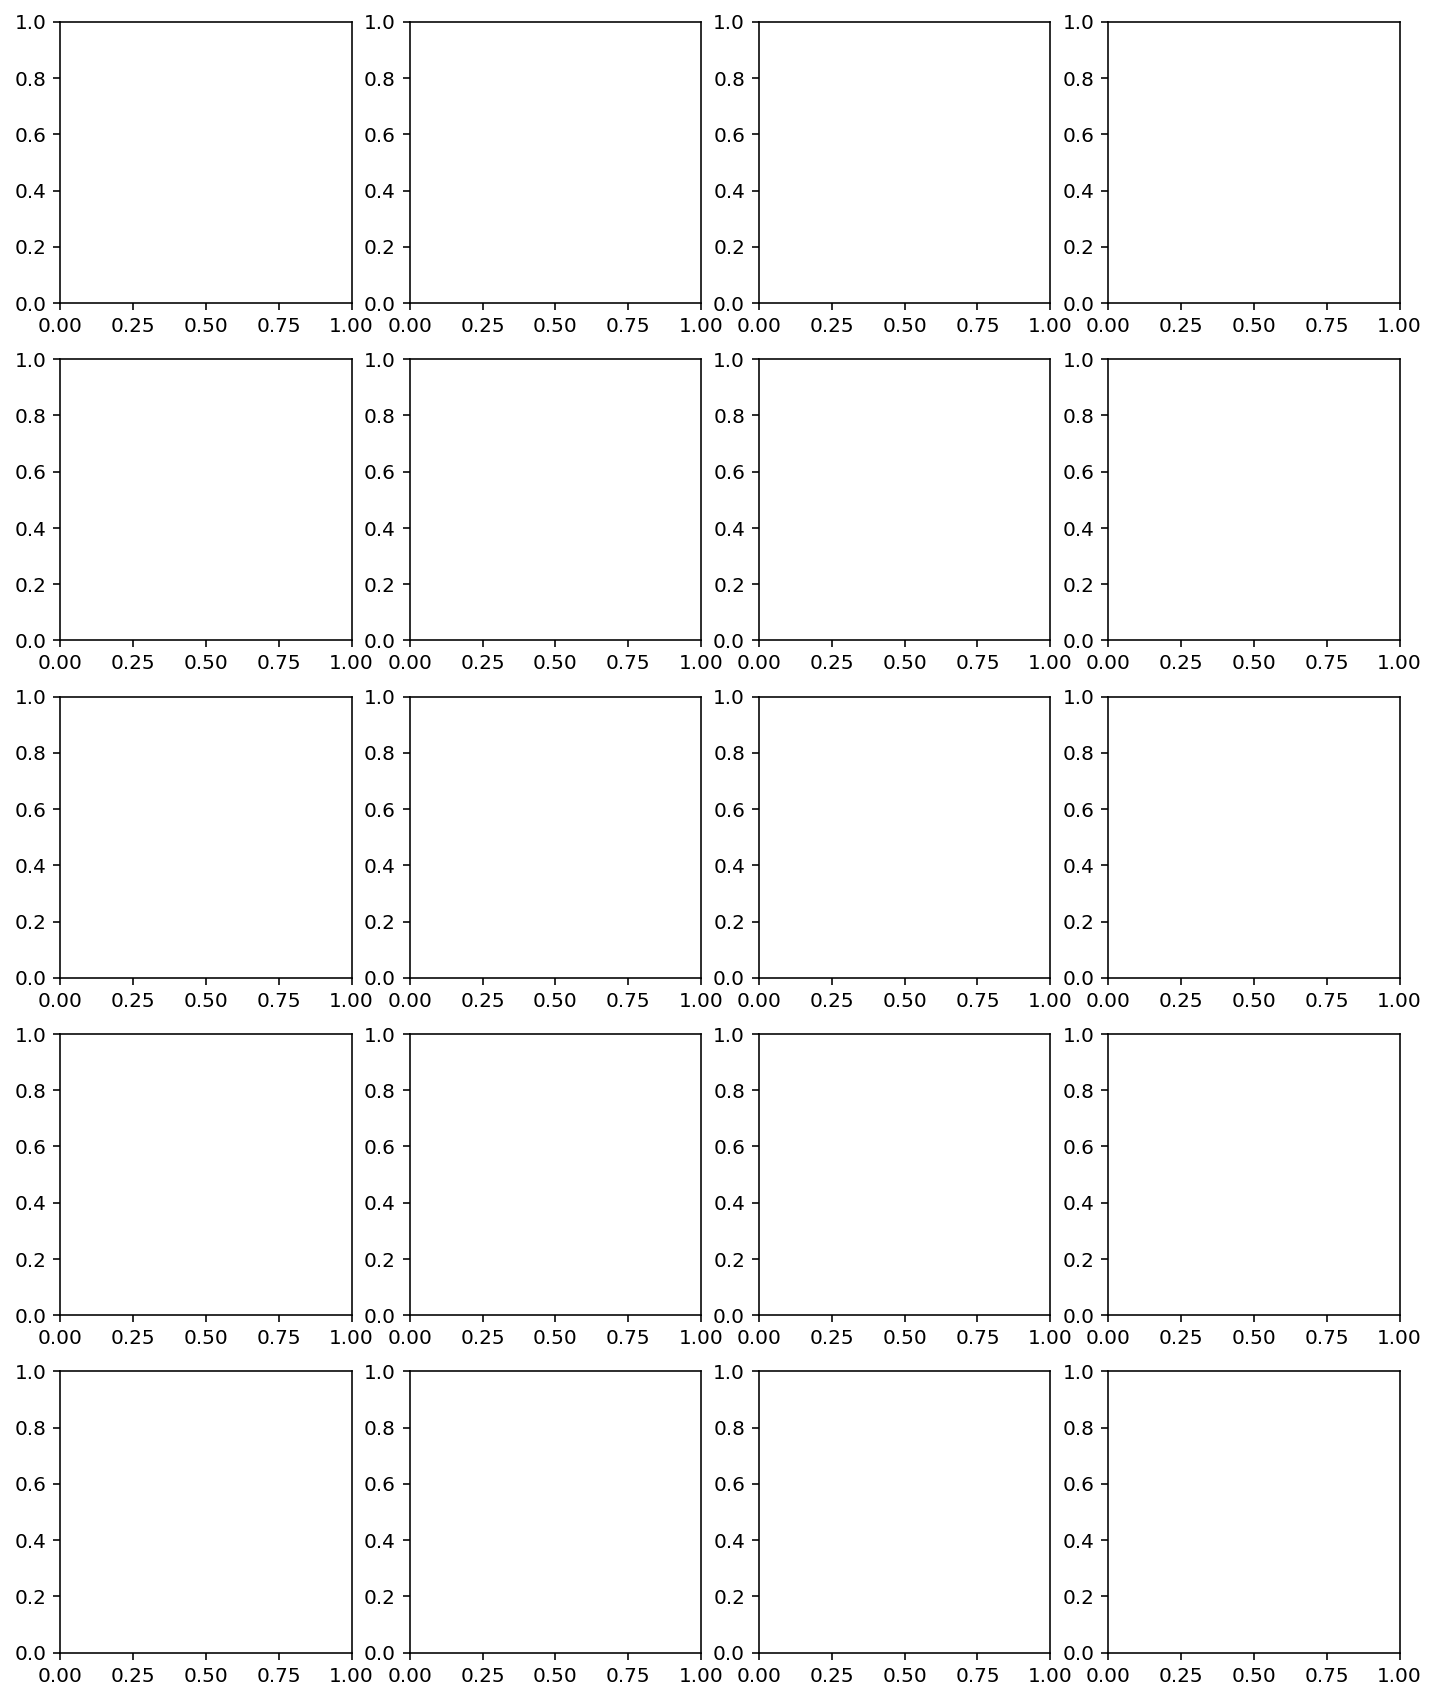

In [6]:
fig, ax = plt.subplots(len(design_types), len(true_params)+1, figsize=(12, 15))

In [7]:

for col, true_p in enumerate(true_params):
    for row, designfunc in enumerate(design_types):
        design_thing = designfunc()
        model = models.Hyperbolic(n_particles=5000)
        model.θ_true = pd.DataFrame.from_dict(true_p)
        fitted_model, _ = simulated_experiment_trial_loop(design_thing, model)
        plot_delay_without_front_end_delays(ax[row,col], design_thing.all_data)
        hyperbolic_posterior_predictive(ax[row,col], fitted_model)
        
        if col > 0:
            ax[row,col].set_ylabel('')
        
        if row < len(design_types)-1:
            ax[row,col].set_xlabel('')

plt.subplots_adjust(hspace=0.4, wspace=0.4)

[ax[r,c].set_xlim([0, 365+7]) for r in range(len(design_types)) for c in range(len(true_params))]
[ax[r,c].set_ylim([0, 1]) for r in range(len(design_types)) for c in range(len(true_params))]
[ax[0,c].set_title(title) for c, title in enumerate(col_titles)]
[ax[r,c].get_legend().remove() for r in range(len(design_types)) for c in range(len(true_params))]

pad = 13 # in points
for axis, row_title in zip(ax[:,0], row_headings):
    axis.annotate(row_title, xy=(0, 0.5), xytext=(-axis.yaxis.labelpad - pad, 0),
                  xycoords=axis.yaxis.label, textcoords='offset points',
                  size='large', ha='center', va='center', rotation=90)

/Users/btvincent/git-local/darc-experiments-python/bad/optimisation.py:153: RuntimeWarning: invalid value encountered in true_divide
  (n_times_sampled+n_times_sampled_iter))
/Users/btvincent/git-local/darc-experiments-python/bad/optimisation.py:226: RuntimeWarning: invalid value encountered in true_divide
  (n_times_sampled + n_times_sampled_iter))


<Figure size 432x288 with 0 Axes>

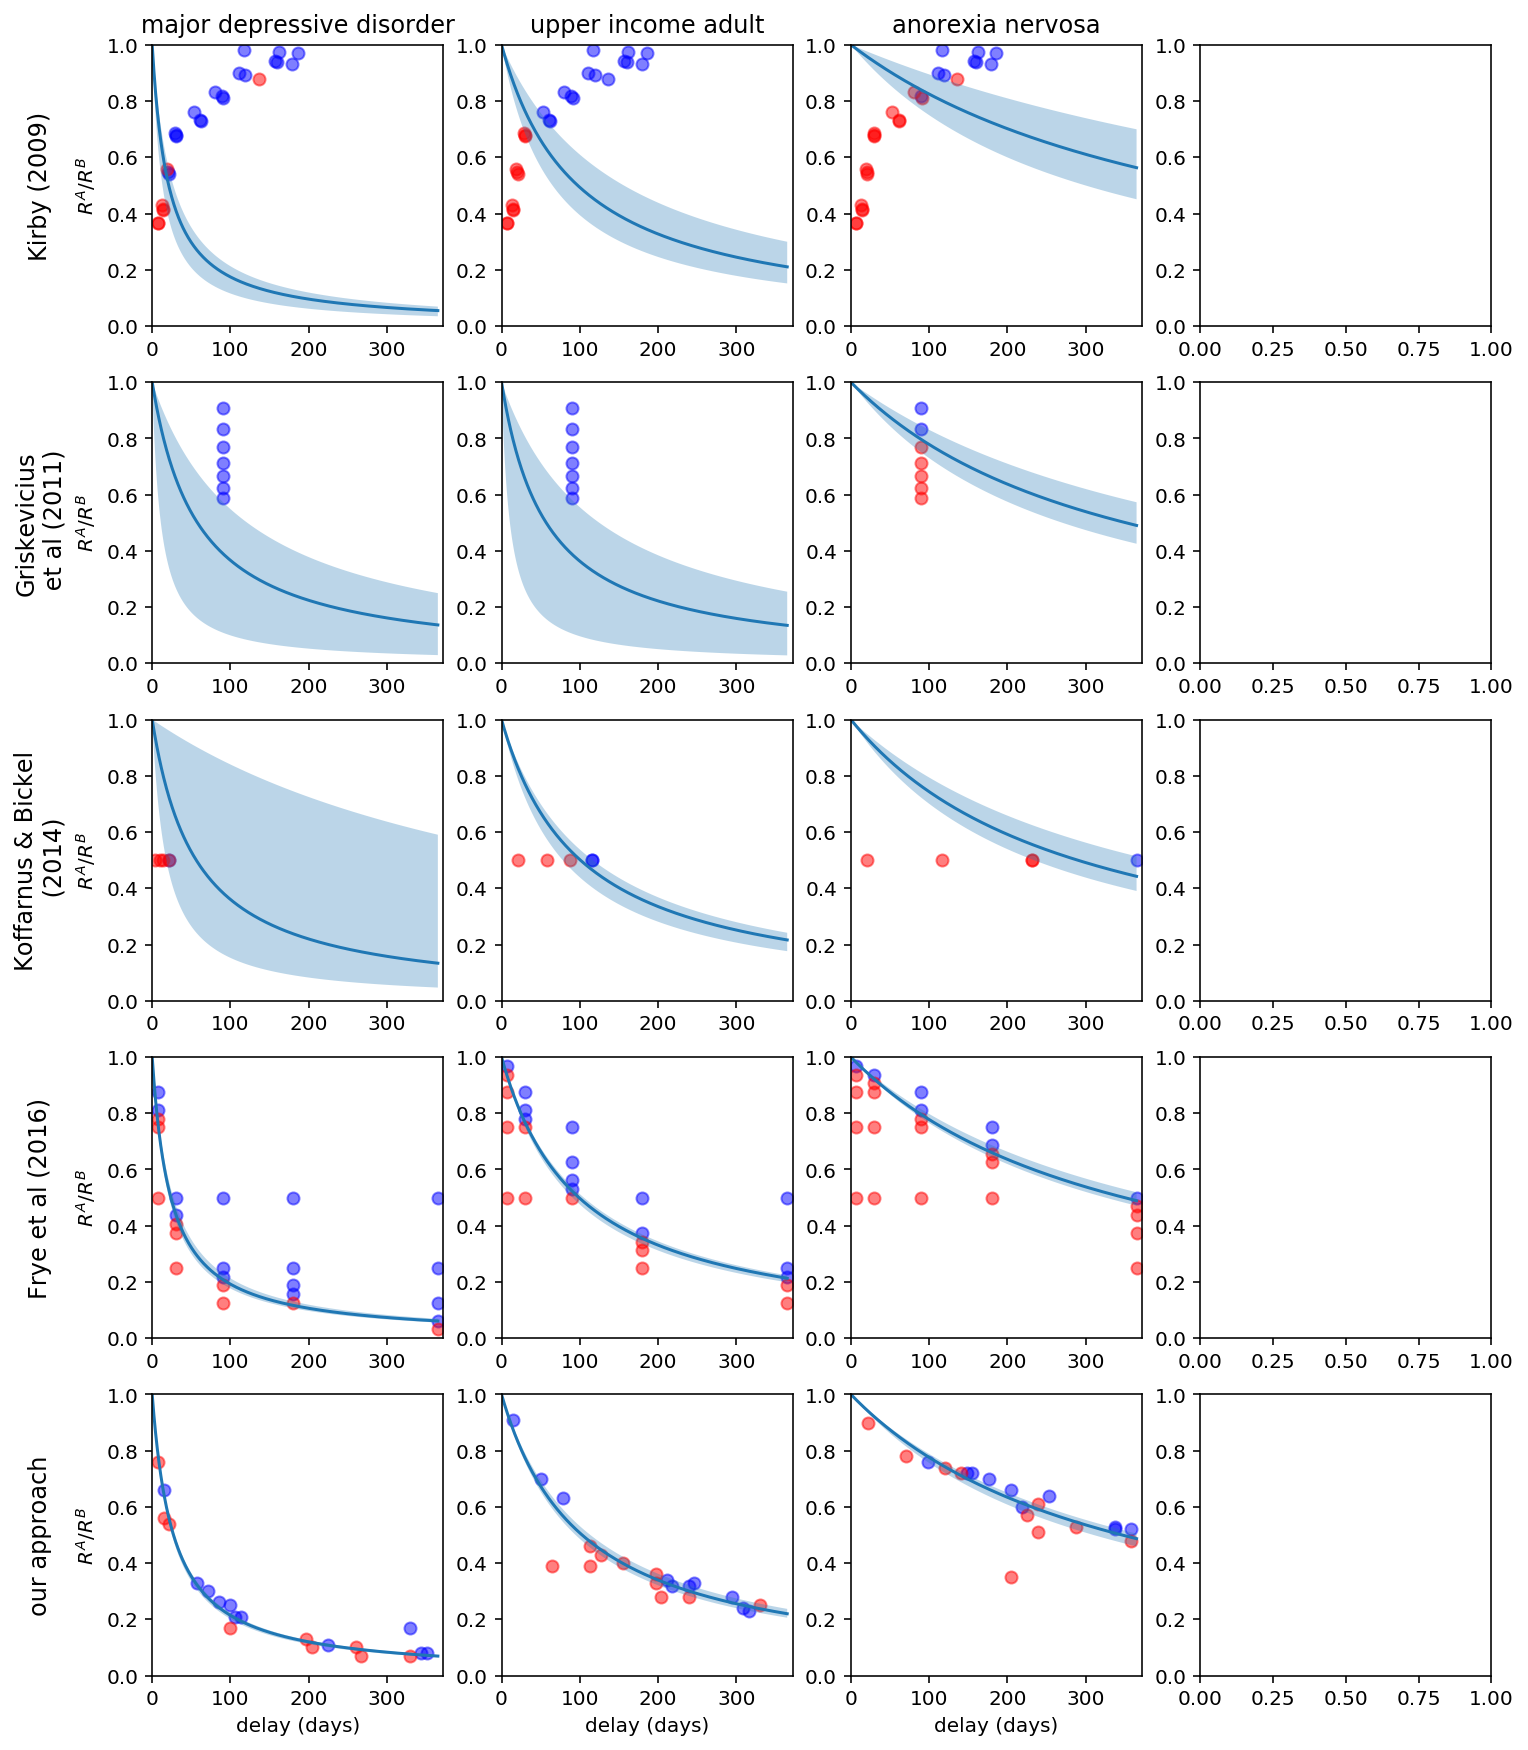

In [8]:
fig

## Code for parameter recovery sweeps
This will fill in the right hand column with parameter recovery sweeps for the corresponding experiment design approaches (rows). This gives a more high level overview of the resulting posterior over a wide range of $\log(k)$ values.

In [9]:
N = 70  # 70
θsweep = pd.DataFrame.from_dict({'logk': np.linspace(-8, -1, num=N), 
                                 'α': np.ones(N) * 2})

In [10]:
target_param_name = 'logk'

# KIRBY -----------------------------------------------------------------
max_trials = 27
design_thing = Kirby2009()
model = models.Hyperbolic(n_particles=5000)
θ_estimated_kirby, _ = parameter_recovery_sweep(θsweep, model, design_thing, target_param_name)
n_trials_kirby = 27

# FRYE -----------------------------------------------------------------
design_thing = Frye(DB=[7, 30, 365/2, 365], trials_per_delay=5)
model = models.Hyperbolic(n_particles=5000)
θ_estimated_frye, _ = parameter_recovery_sweep(θsweep, model, design_thing, target_param_name)
n_trials_frye = 20

# Griskevicius -----------------------------------------------------------------
design_thing = Griskevicius2011()
model = models.Hyperbolic(n_particles=5000)
θ_estimated_griskevicius, _ = parameter_recovery_sweep(θsweep, model, design_thing, target_param_name)
n_trials_griskevicius = 7

# Koffarnus & Bickel ----------------------------------------------------------
design_thing = Koffarnus_Bickel()
model = models.Hyperbolic(n_particles=5000)
θ_estimated_koffarnus, _ = parameter_recovery_sweep(θsweep, model, design_thing, target_param_name)
n_trials_koffarnus = 5

# DARC -----------------------------------------------------------------
max_trials = 20
design_thing = DARCDesign(max_trials=max_trials, RA=list(np.arange(5, 99+1, 1)))
model = models.Hyperbolic(n_particles=5000)
θ_estimated_darc, _ = parameter_recovery_sweep(θsweep, model, design_thing, target_param_name)
n_trials_darc = max_trials

starting parameter recovery sweep
starting parameter recovery sweep
starting parameter recovery sweep
starting parameter recovery sweep
starting parameter recovery sweep


In [11]:
def my_errorbar(ax, θsweep, θ_estimated):
    err_lower = θ_estimated['logk_median'] - θ_estimated['logk_lower95']
    err_upper = θ_estimated['logk_upper95'] - θ_estimated['logk_median']
        
    ax.plot([-8, -1], [-8, -1], c=[0.7, 0.7, 0.7])
    ax.errorbar(x=θsweep['logk'], 
                y=θ_estimated['logk_median'],
                yerr=[err_lower, err_upper],
                fmt='o',
                c='k', 
                ms=3)
    ax.set_xlabel(r'true $\log(k)$')
    ax.set_ylabel(r'estimated $\log(k)$')
    return

col = 3
ax[0,col].set_title('Parameter recovery\nsimulations')
# -----------------------------------------------------
my_errorbar(ax[0,col], θsweep, θ_estimated_kirby)
my_errorbar(ax[1,col], θsweep, θ_estimated_griskevicius)
my_errorbar(ax[2,col], θsweep, θ_estimated_koffarnus)
my_errorbar(ax[3,col], θsweep, θ_estimated_frye)
my_errorbar(ax[4,col], θsweep, θ_estimated_darc)

# remove x-labels
[ax[i,col].set_xlabel('') for i in range(4)]

# move y axis to the right side
[ax[i,col].yaxis.tick_right() for i in range(5)]

# move y label to the right side
[ax[i,col].yaxis.set_label_position("right") for i in range(5)];

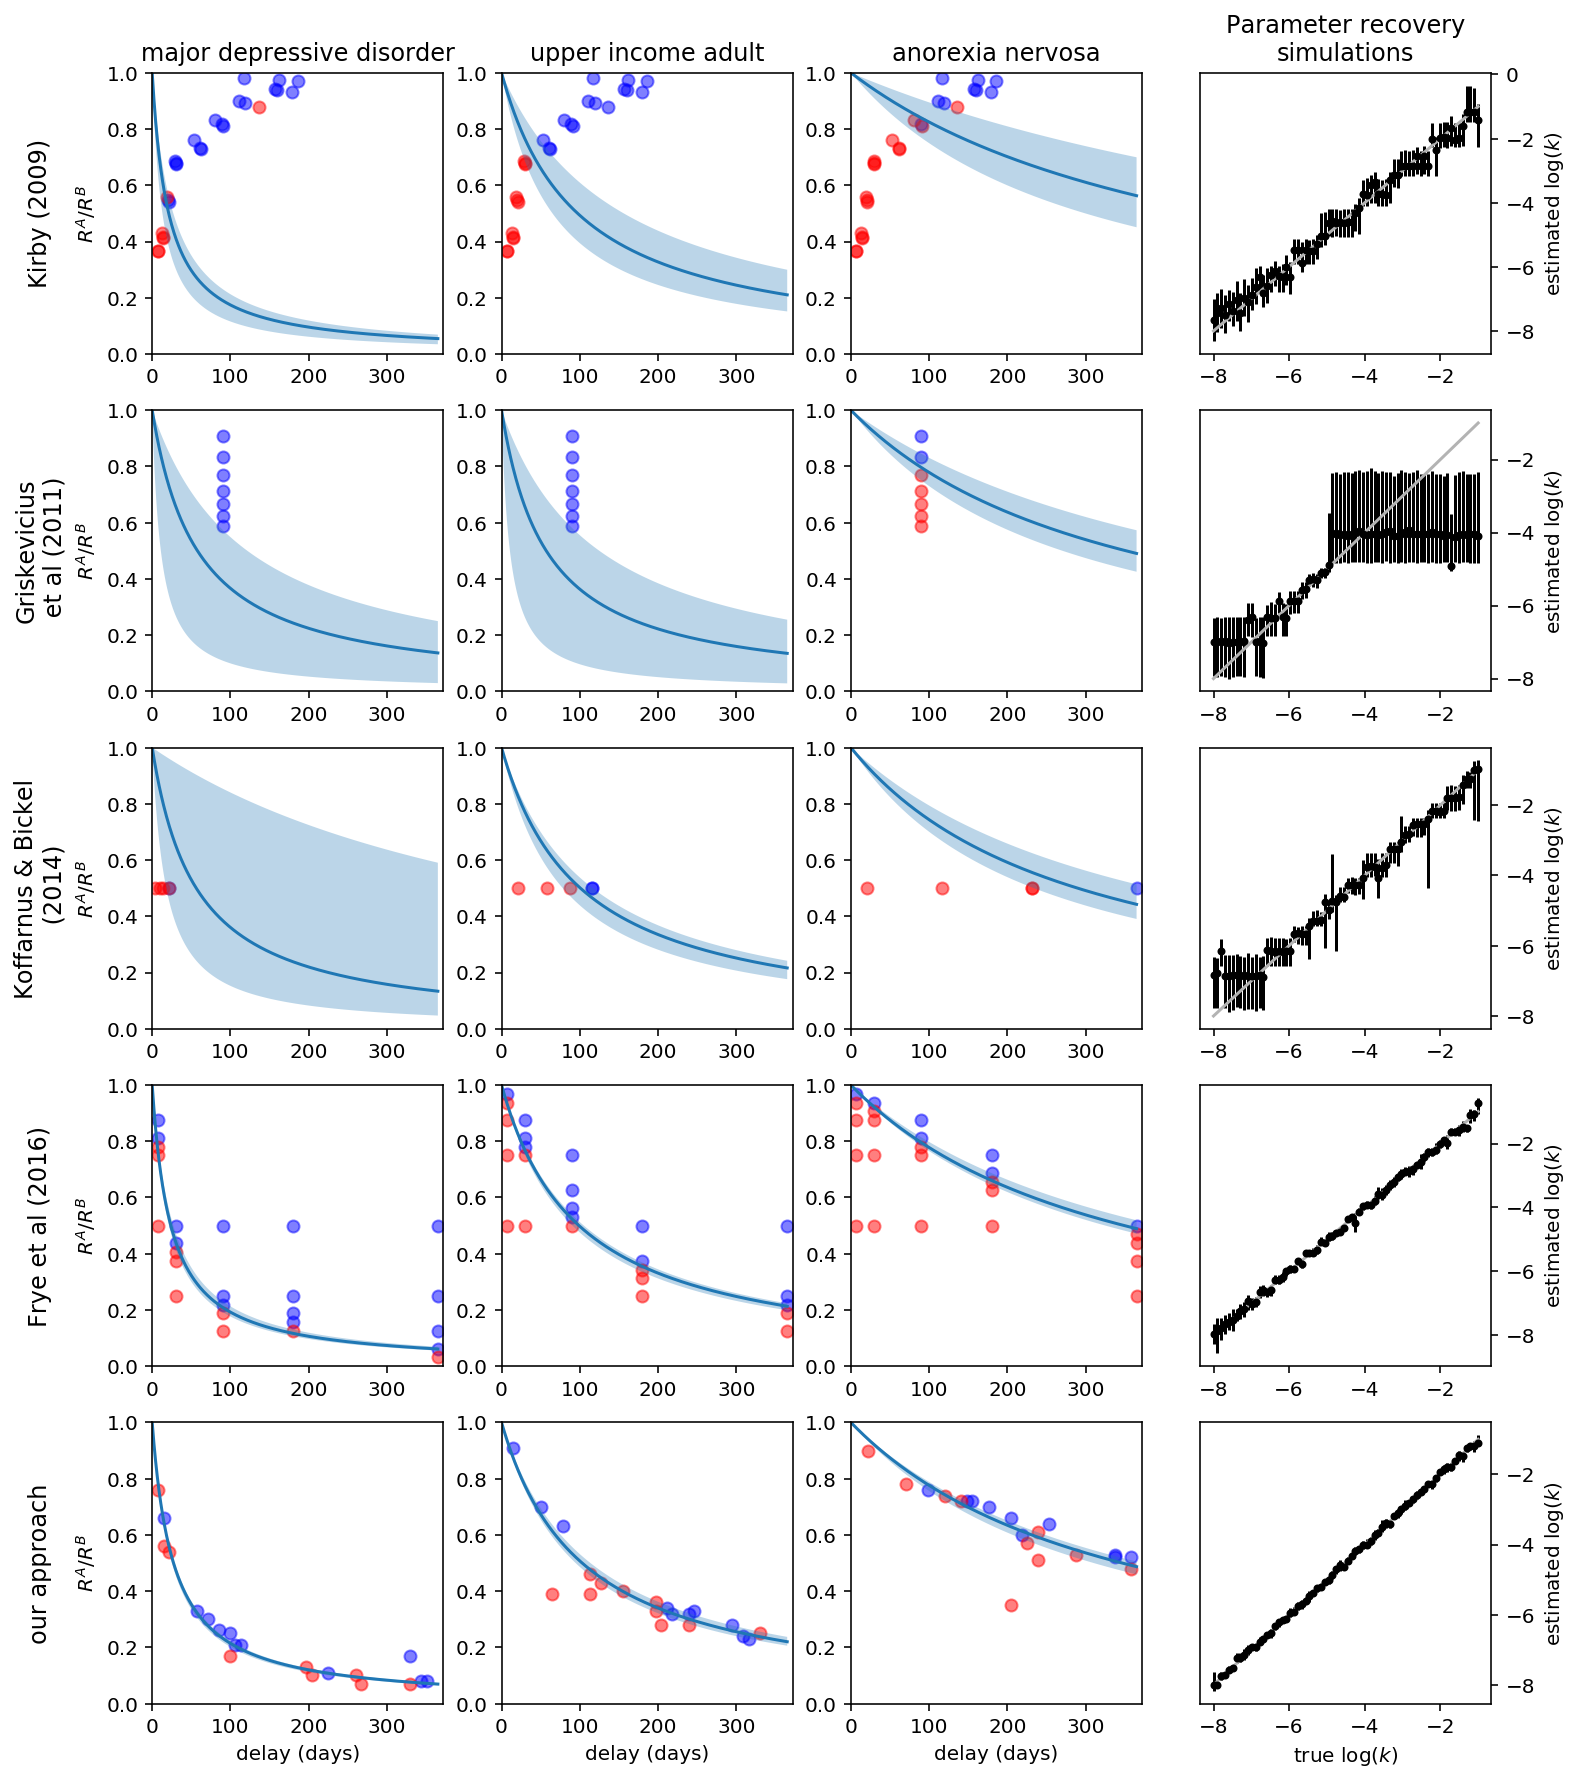

In [12]:
fig

In [13]:
fig.savefig('delayed_choice_demo.pdf', bbox_inches='tight')